In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 100

ng =7

ng_refs = (/ 5 , 2 /) 

nref =2

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66/

data wgt
     &     /0 , 0.6 , 0.5 , 0.7,
     &     0.8 , 0.8 , 0.7/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

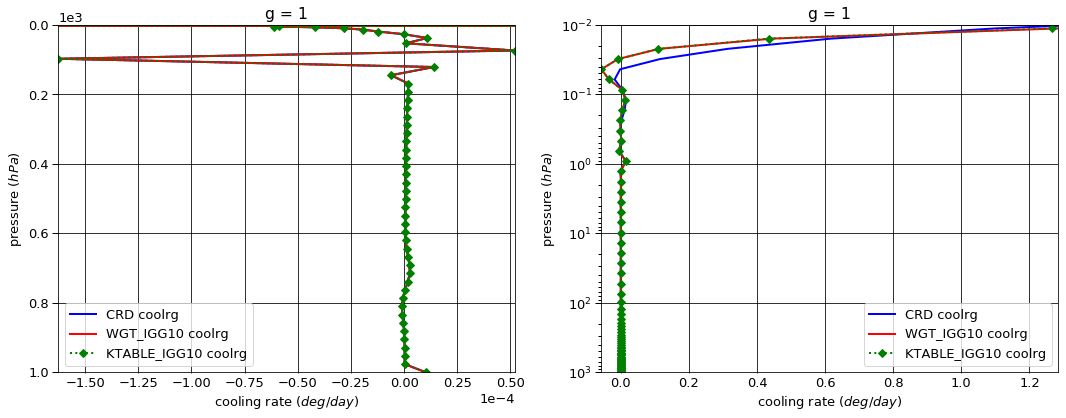

# Figure: cooling rate g-group 2

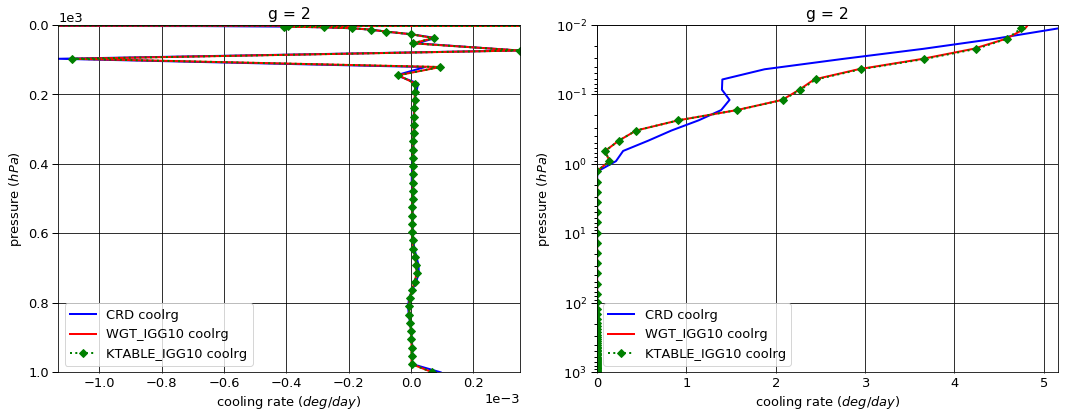

# Figure: cooling rate g-group 3

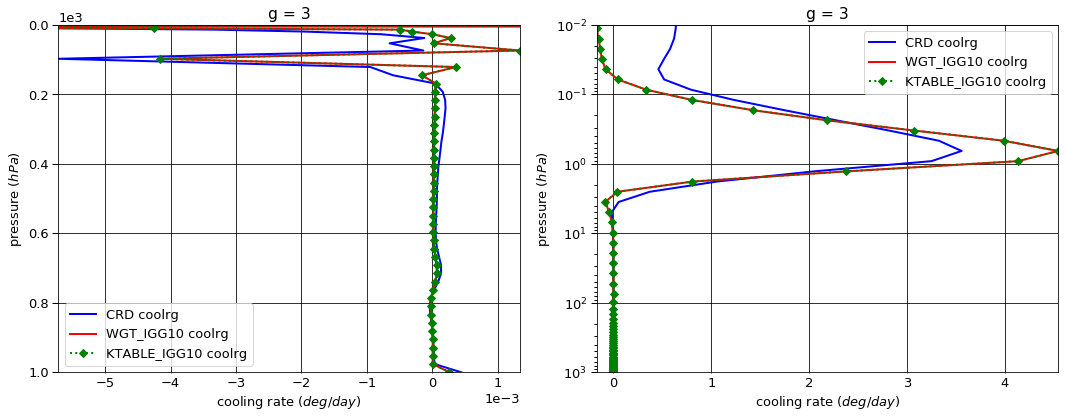

# Figure: cooling rate g-group 4

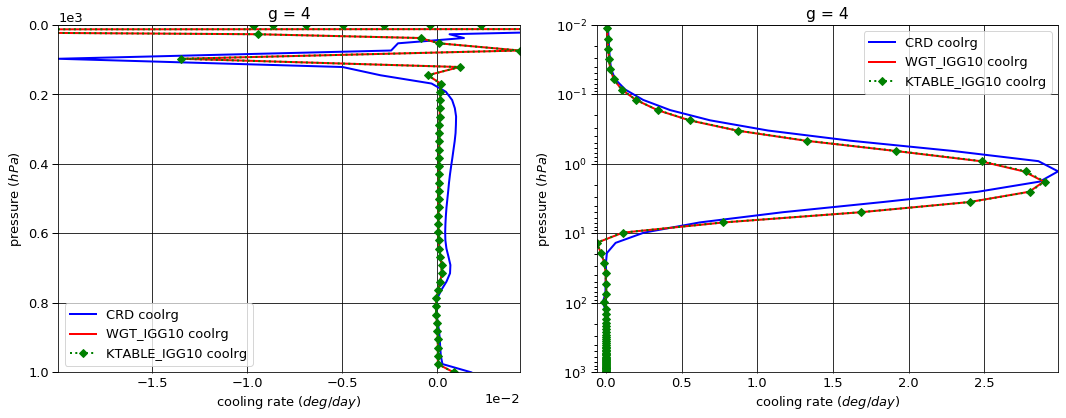

# Figure: cooling rate g-group 5

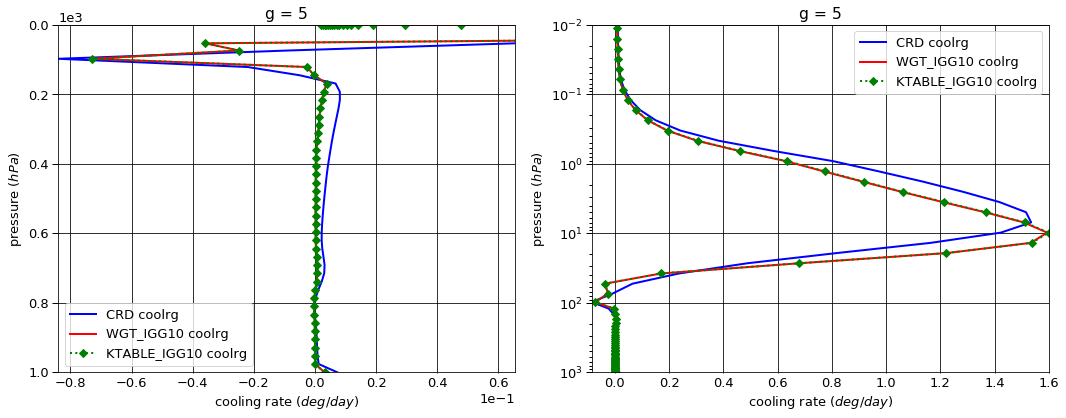

# Figure: cooling rate g-group 6

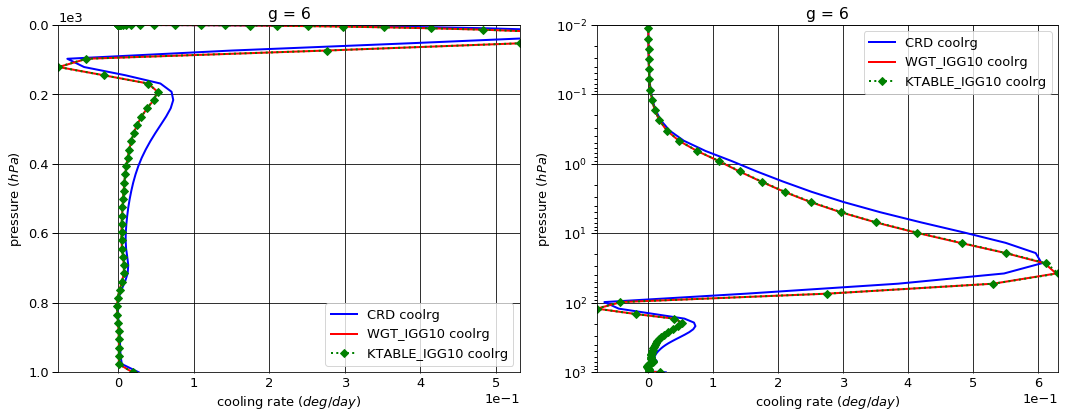

# Figure: cooling rate g-group 7

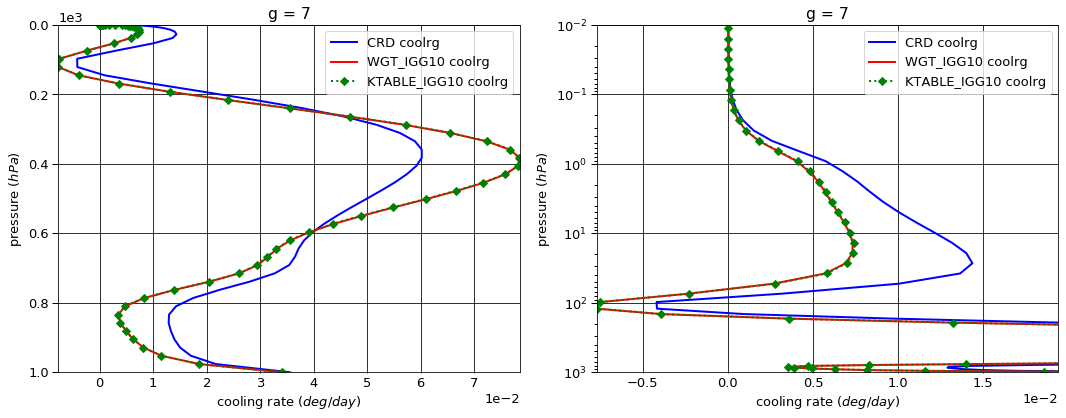

# Figure: cooling rate g-group total

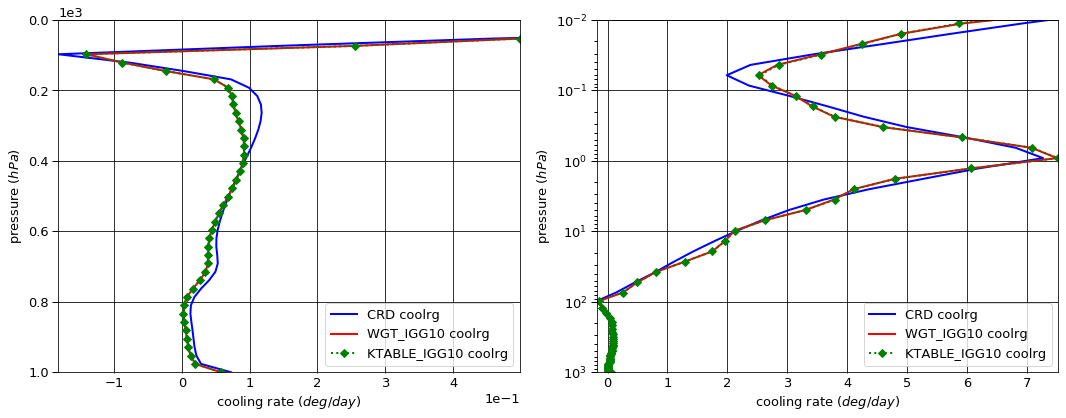

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009763   0.000000 -0.009763
  1013.0   76     -0.037764   0.037735 -0.000029
2 0.0      1      -0.092557   0.000000 -0.092557
  1013.0   76     -0.252364   0.252097 -0.000267
3 0.0      1      -0.553961   0.000000 -0.553961
  1013.0   76     -0.967252   0.965965 -0.001287
4 0.0      1      -1.588963   0.000000 -1.588963
  1013.0   76     -3.130768   3.124845 -0.005923
5 0.0      1      -4.102802   0.000000 -4.102802
  1013.0   76    -11.539651  11.513873 -0.025778
6 0.0      1      -6.061602   0.000000 -6.061602
  1013.0   76    -22.157661  22.064047 -0.093614
7 0.0      1      -3.965887   0.000000 -3.965887
  1013.0   76     -8.982089   8.701371 -0.280718


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009814   0.000000 -0.009814
  1013.0   76     -0.037764   0.037735 -0.000029
2 0.0      1      -0.082176   0.000000 -0.082176
  1013.0   76     -0.252364   0.252173 -0.000191
3 0.0      1      -0.569370   0.000000 -0.569370
  1013.0   76     -0.967252   0.966520 -0.000732
4 0.0      1      -1.661018   0.000000 -1.661018
  1013.0   76     -3.130768   3.128399 -0.002369
5 0.0      1      -4.204182   0.000000 -4.204182
  1013.0   76    -11.539651  11.530912 -0.008738
6 0.0      1      -5.449800   0.000000 -5.449800
  1013.0   76    -22.157661  22.104442 -0.053219
7 0.0      1      -3.840806   0.000000 -3.840806
  1013.0   76     -8.982089   8.805832 -0.176257


KTABLE_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009812   0.000000 -0.009812
  1013.0   76     -0.037764   0.037735 -0.000029
2 0.0      1      -0.082244   0.000000 -0.082244
  1013.0   76     -0.252364   0.252173 -0.000191
3 0.0      1      -0.569356   0.000000 -0.569356
  1013.0   76     -0.967252   0.966520 -0.000732
4 0.0      1      -1.661807   0.000000 -1.661807
  1013.0   76     -3.130768   3.128399 -0.002369
5 0.0      1      -4.206718   0.000000 -4.206718
  1013.0   76    -11.539651  11.530912 -0.008738
6 0.0      1      -5.452608   0.000000 -5.452608
  1013.0   76    -22.157661  22.104522 -0.053139
7 0.0      1      -3.835101   0.000000 -3.835101
  1013.0   76     -8.982089   8.806187 -0.175902


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -5.103870e-05  0.000000 -5.103870e-05
  1013.0   76    -6.938894e-18  0.000000 -3.388132e-21
2 0.0      1      1.038086e-02  0.000000  1.038086e-02
  1013.0   76     0.000000e+00  0.000076  7.578160e-05
3 0.0      1     -1.540929e-02  0.000000 -1.540929e-02
  1013.0   76     0.000000e+00  0.000555  5.551994e-04
4 0.0      1     -7.205580e-02  0.000000 -7.205580e-02
  1013.0   76     0.000000e+00  0.003554  3.553994e-03
5 0.0      1     -1.013800e-01  0.000000 -1.013800e-01
  1013.0   76     0.000000e+00  0.017039  1.703958e-02
6 0.0      1      6.118020e-01  0.000000  6.118020e-01
  1013.0   76    -3.552714e-15  0.040395  4.039513e-02
7 0.0      1      1.250809e-01  0.000000  1.250809e-01
  1013.0   76     0.000000e+00  0.104461  1.044612e-01


KTABLE_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -4.866880e-05  0.000000 -4.866880e-05
  1013.0   76    -6.938894e-18  0.000000 -3.388132e-21
2 0.0      1      1.031315e-02  0.000000  1.031315e-02
  1013.0   76     0.000000e+00  0.000076  7.578160e-05
3 0.0      1     -1.539495e-02  0.000000 -1.539495e-02
  1013.0   76     0.000000e+00  0.000555  5.551994e-04
4 0.0      1     -7.284430e-02  0.000000 -7.284430e-02
  1013.0   76     0.000000e+00  0.003554  3.553994e-03
5 0.0      1     -1.039159e-01  0.000000 -1.039159e-01
  1013.0   76     0.000000e+00  0.017039  1.703958e-02
6 0.0      1      6.089933e-01  0.000000  6.089933e-01
  1013.0   76    -3.552714e-15  0.040475  4.047496e-02
7 0.0      1      1.307857e-01  0.000000  1.307857e-01
  1013.0   76     0.000000e+00  0.104816  1.048157e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      36.776670
  1001.112500 75      0.000010
2 0.000312    1       7.011048
  1001.112500 75      0.000095
3 0.000312    1       0.426906
  1001.112500 75      0.000444
4 0.000312    1      -0.014538
  1001.112500 75      0.001773
5 0.000312    1       0.006669
  1001.112500 75      0.007319
6 0.000312    1       0.000285
  1001.112500 75      0.027551
7 0.000312    1       0.000013
  1001.112500 75      0.035622


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      18.282647
  1001.112500 75      0.000010
2 0.000312    1       4.102021
  1001.112500 75      0.000068
3 0.000312    1      -0.349697
  1001.112500 75      0.000262
4 0.000312    1      -0.014045
  1001.112500 75      0.000849
5 0.000312    1       0.004717
  1001.112500 75      0.003132
6 0.000312    1       0.000295
  1001.112500 75      0.019356
7 0.000312    1       0.000009
  1001.112500 75      0.034137


KTABLE_IGG10


coolrg
g pressure    layer           
1 0.000312    1      18.414256
  1001.112500 75      0.000010
2 0.000312    1       3.750115
  1001.112500 75      0.000068
3 0.000312    1      -0.285954
  1001.112500 75      0.000262
4 0.000312    1      -0.009665
  1001.112500 75      0.000849
5 0.000312    1       0.001855
  1001.112500 75      0.003132
6 0.000312    1      -0.000349
  1001.112500 75      0.019323
7 0.000312    1       0.000002
  1001.112500 75      0.034110


WGT_IGG10 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -18.494023
  1001.112500 75      0.000000
2 0.000312    1      -2.909027
  1001.112500 75     -0.000026
3 0.000312    1      -0.776602
  1001.112500 75     -0.000181
4 0.000312    1       0.000493
  1001.112500 75     -0.000924
5 0.000312    1      -0.001952
  1001.112500 75     -0.004187
6 0.000312    1       0.000010
  1001.112500 75     -0.008195
7 0.000312    1      -0.000004
  1001.112500 75     -0.001485


KTABLE_IGG10 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -18.362414
  1001.112500 75      0.000000
2 0.000312    1      -3.260933
  1001.112500 75     -0.000026
3 0.000312    1      -0.712860
  1001.112500 75     -0.000181
4 0.000312    1       0.004873
  1001.112500 75     -0.000924
5 0.000312    1      -0.004814
  1001.112500 75     -0.004187
6 0.000312    1      -0.000634
  1001.112500 75     -0.008228
7 0.000312    1      -0.000012
  1001.112500 75     -0.001512

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.375535,0.000000,-16.375535
1013.0,76,-47.067549,46.659934,-0.407615



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.817167,0.000000,-15.817167
1013.0,76,-47.067549,46.826014,-0.241534



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.817646,0.000000,-15.817646
1013.0,76,-47.067549,46.826449,-0.241100



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,5.583676e-01,0.00000,0.558368
1013.0,76,-7.105427e-15,0.16608,0.166081



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,5.578883e-01,0.000000,0.557888
1013.0,76,-7.105427e-15,0.166515,0.166515


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,44.207053
1001.112500,75,0.072814



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,22.025947
1001.112500,75,0.057815



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,21.870259
1001.112500,75,0.057755



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-22.181106
1001.112500,75,-0.014999



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-22.336794
1001.112500,75,-0.015059


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00080,0.000804
2,0.00535,0.005369
3,0.02050,0.020583
4,0.06635,0.066649
5,0.24470,0.245503
6,0.47055,0.470883
7,0.19175,0.190211


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.230874e-17
2,6.648507e-19
3,3.591161e-20
4,1.939749e-21
5,1.047746e-22
6,5.656349e-23
7,3.056898e-24


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.230874e-17,NaN,0.00080,0.000804,0.00080,0.000804,1.0
2,6.648507e-19,0.054015,0.00535,0.005369,0.00615,0.006172,1.0
3,3.591161e-20,0.054015,0.02050,0.020583,0.02665,0.026755,1.0
4,1.939749e-21,0.054015,0.06635,0.066649,0.09300,0.093403,1.0
5,1.047746e-22,0.054015,0.24470,0.245503,0.33770,0.338906,1.0
6,5.656349e-23,0.539859,0.47055,0.470883,0.80825,0.809789,10.0
7,3.056898e-24,0.054044,0.19175,0.190211,1.00000,1.000000,10.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.473172e-17  1.906993e-17   2.870054  1.009463e-01
      2 0.000312     1.005444e-18  5.354672e-19   1.877695  4.327173e-03
      3 0.000312     4.946705e-20  1.509277e-20   3.277532  1.708730e-04
      4 0.000312     1.324176e-21  4.444970e-22   2.979043  5.612529e-06
      5 0.000312     3.047652e-23  1.044050e-23   2.919066  1.401148e-07
      6 0.000312     4.631149e-25  4.142556e-25   1.117945  2.399762e-09
      7 0.000312     1.583055e-25  7.558234e-26   2.094477  7.066187e-10
2     1 0.000750     5.473450e-17  1.909782e-17   2.866008  4.071927e-02
      2 0.000750     1.009940e-18  5.376009e-19   1.878606  1.750499e-03
      3 0.000750     4.967334e-20  1.519536e-20   3.268981  6.915466e-05
      4 0.000750     1.333810e-21  4.493869e-22   2.968066  2.278159e-06
      5 0.000750     3.081816e-23  1.065947e-23   2.891152  5.711247e-08
      6 0.000750     4.802251e-25  4.307484e-25   1.114862  1.002810e-09
      7 0.000750     1.608596e-25  7.677815e-26   2.095122  2.891936e-10
3     1 0.001052     5.473934e-17  1.914978e-17   2.858485  5.725948e-02
      2 0.001052     1.018708e-18  5.414464e-19   1.881456  2.475203e-03
      3 0.001052     5.004592e-20  1.533177e-20   3.264197  9.774248e-05
      4 0.001052     1.350149e-21  4.553683e-22   2.964960  3.234421e-06
      5 0.001052     3.131424e-23  1.088952e-23   2.875630  8.141794e-08
      6 0.001052     4.982380e-25  4.474576e-25   1.113487  1.459407e-09
      7 0.001052     1.653060e-25  7.840104e-26   2.108466  4.163231e-10
4     1 0.001476     5.474388e-17  1.920325e-17   2.850761  8.055319e-02
      2 0.001476     1.027738e-18  5.454543e-19   1.884187  3.501895e-03
      3 0.001476     5.043871e-20  1.548490e-20   3.257284  1.382671e-04
      4 0.001476     1.367629e-21  4.622473e-22   2.958652  4.597526e-06
      5 0.001476     3.186630e-23  1.116713e-23   2.853579  1.163061e-07
      6 0.001476     5.201604e-25  4.680114e-25   1.111427  2.138202e-09
      7 0.001476     1.700922e-25  8.023864e-26   2.119829  6.004228e-10
5     1 0.002070     5.474808e-17  1.925792e-17   2.842886  1.133045e-01
      2 0.002070     1.036946e-18  5.496167e-19   1.886671  4.954013e-03
      3 0.002070     5.085111e-20  1.565931e-20   3.247341  1.956579e-04
      4 0.002070     1.386337e-21  4.702997e-22   2.947773  6.539692e-06
      5 0.002070     3.248635e-23  1.150863e-23   2.822780  1.664497e-07
      6 0.002070     5.473098e-25  4.937423e-25   1.108493  3.157079e-09
      7 0.002070     1.752414e-25  8.235066e-26   2.127990  8.670799e-10
6     1 0.002904     5.475199e-17  1.931426e-17   2.834796  1.594015e-01
      2 0.002904     1.046373e-18  5.539902e-19   1.888794  7.010302e-03
      3 0.002904     5.128874e-20  1.586319e-20   3.233192  2.771040e-04
      4 0.002904     1.406670e-21  4.799837e-22   2.930661  9.314914e-06
      5 0.002904     3.319848e-23  1.193900e-23   2.780675  2.388975e-07
      6 0.002904     5.817087e-25  5.266691e-25   1.104505  4.710019e-09
      7 0.002904     1.808611e-25  8.484412e-26   2.131687  1.254925e-09
7     1 0.004074     5.475564e-17  1.937297e-17   2.826394  2.242838e-01
      2 0.004074     1.056081e-18  5.586556e-19   1.890398  9.922904e-03
      3 0.004074     5.175962e-20  1.610793e-20   3.213301  3.928565e-04
      4 0.004074     1.429185e-21  4.919360e-22   2.905226  1.329070e-05
      5 0.004074     3.403663e-23  1.249300e-23   2.724457  3.441645e-07
      6 0.004074     6.262023e-25  5.696288e-25   1.099317  7.118648e-09
      7 0.004074     1.871039e-25  8.787088e-26   2.129305  1.821480e-09
8     1 0.005714     5.475912e-17  1.943503e-17   2.817547  3.156064e-01
      2 0.005714     1.066162e-18  5.637281e-19   1.891270  1.404983e-02
      3 0.005714     5.227518e-20  1.640918e-20   3.185728  5.576842e-04
      4 0.005714     1.454679e-21  5.070374e-22   2.868977  1.900595e-05
      5 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
